In [78]:
#Linear Classification

In [28]:
#导入包
from numpy import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
#import numpy as np
import scipy

In [3]:
#获取数据
def get_data(fileName):
    data = load_svmlight_file(fileName)
    return data[0],data[1]
x_train,y_train = get_data("a9a")
x_test,y_test = get_data("a9a.t")

In [4]:
m,n = x_train.shape
x = scipy.sparse.csr.csr_matrix(ones((m,n+1)))
x[:,1:n+1] = x_train
x_train = x
#print(x_test.shape)
#x_test少了一维特征
x = scipy.sparse.csr.csr_matrix(zeros((x_test.shape[0],n)))
print(n,x_train.shape)
x[:,:n-1] = x_test;
x_test = x
x = scipy.sparse.csr.csr_matrix(ones((x_test.shape[0],n+1)));x[:,1:n+1] = x_test;x_test = x

123 (32561, 124)


C:\Users\acer\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [69]:
#批量数量
batch = 50

In [68]:
def predict(X,weights):
    
    y = X*weights

    return y

In [74]:
#calculata the correct rate
def cul_accuracy(y,label):
    n = label.shape[1]
    count = 0.0
    #阈值选为1.0
    theta = 1.0
    y[y>=theta] = 1.0
    y[y<=-theta] = -1.0 
    for i in range(n):
        if(y[i,:] == label[:,i]):
            count +=1.0
    
    
    return (count/n)

In [8]:
#损失函数
delta =800
def loss(y,label,weights):
    m = y.shape[0]
    a = sum(np.power(weights,2))
    b = []
    
    for i in range(m):
        c = 1-label[:,i]*y[i,:]
        b.append(max(c,0))
    return  ( 1/(delta) * a +  sum(b)) / (2*m)

In [55]:
def SGD(weights,alpha,X,h,label,m,index):
    #SGD
    #index = random.randint(0,m)
    end = index + batch
    
    
    grad = mat(zeros(weights.shape))
    for i in range(index,index+batch):
        Wx = X[i,:] * weights 
        if(1 - label[:,i]*Wx   >= 0):
            #print(linalg.norm(weights).shape)
            grad += 1/delta*weights -  (label[:,i]* X[i,:]).T 
        else:
            grad += 1/delta*weights
    return grad/batch

In [22]:
def NAG(weights,alpha,x,h,y,m,v,index):
    r = 0.9
    grad = SGD(weights - r*v,alpha,x,h,y,m,index)
    v = r*v + alpha*grad
    weights = weights - v

    return weights,v#,h_nag

In [23]:
def Adagrad(weights,alpha,x,h,y,m,G,index):
    
    grad = SGD(weights,alpha,x,h,y,m,index)
    G = G+multiply(grad,grad)
    ele = 1e-8
    weights = (weights  - multiply(alpha / sqrt(G + ele) , grad))
    return weights ,G

In [24]:
def RMSProp(weights,alpha,x,h,y,m,G,index):
    r = 0.9
    grad = SGD(weights,alpha,x,h,y,m,index)
    G = r*G + (1-r)*multiply(grad,grad)
    ele = 1e-8
    weights = (weights  - multiply(alpha / sqrt(G + ele) , grad))
    return weights ,G

In [25]:
def Adam(weights,x,h,y,m,G,moment,a,k,eta,index):
    #给各内部参数赋值
    #eta = 0.001
    r = 0.999
    b = 0.9
    ele = 1e-8
    
    grad = SGD(weights,eta,x,h,y,m,index)

    moment = b * moment + (1-b)*grad
    G = r*G + (1-r)*multiply(grad,grad)
    alpha = eta * sqrt(1- pow(r,k)) /(1 - pow(b,k))
    #print(pow(r,k))
    weights = weights - alpha * moment / sqrt(G+ele)
    
    return weights , G ,moment 

In [26]:
def GD(x_train,y_train,x_test,y_test,alpha = 0.03 , max_iter = 1000):
    m,n = x_train.shape
    weights_nag = mat(zeros(n)).T
    weights_adagrad = mat(zeros(n)).T
    weights_RMSProp = mat(zeros(n)).T
    weights_adam = mat(zeros(n)).T
    iter_list = []
    train_list = []
    test_list = []
    y_train = mat(y_train)
    y_test = mat(y_test)

    #训练损失值
    train_adagrad = []
    train_nag =[]
    train_RMSProp = []
    train_adam =[]
    
    #准确度
    acc_nag     = []
    acc_adagrad =[]
    acc_RMSProp = []
    acc_adam    = []
    
    
    G = weights_nag.copy()
    G_RMSProp = weights_nag.copy()
    G_adam = weights_nag.copy()
    v = weights_nag.copy()
    moment = weights_nag.copy()
    #h_nag = sigmoid(x_train,weights_nag)
    alpha_adam = alpha
    for k in range(max_iter):
      
        print(k)
        
        #choose the random index
        index = random.randint(0,m-batch)
        h_adagrad = predict(x_train,weights_adagrad)
        h_RMSProp = predict(x_train,weights_RMSProp)
        h_adam = predict(x_train,weights_adam)
        h_nag = predict(x_train,weights_nag)
        #updata v,G,moment 
        #NAG
        weights_nag,v= NAG(weights_nag,alpha,x_train,h_nag,y_train,m,v,index)
        
        #Adagrad
        weights_adagrad,G = Adagrad(weights_adagrad,alpha,x_train,h_adagrad,y_train,m,G,index)
        
        #RMS
        weights_RMSProp,G_RMSProp =  \
                RMSProp(weights_RMSProp,alpha,x_train,h_RMSProp,y_train,m,G_RMSProp,index)
            
        #Adam
        weights_adam,G_adam,moment = \
                Adam(weights_adam,x_train,h_adam,y_train,m,G_adam,moment,alpha_adam,k+1,alpha,index)
        
        #print(weights_nag.shape,weights_adagrad.shape)
        
        
        nag_loss = loss(h_nag,y_train,weights_nag)
        adagrad_loss = loss(h_adagrad,y_train,weights_adagrad)
        RMS_loss = loss(h_RMSProp,y_train,weights_RMSProp)
        adam_loss = loss(h_adam,y_train,weights_adam)
        
        #添加进损失集合
        iter_list.append(k)
        train_nag.append(nag_loss)
        train_adagrad.append(adagrad_loss)
        train_RMSProp.append(RMS_loss)
        train_adam.append(adam_loss)
        
        #添加进准确率集合
        #acc_nag.append(cul_accuracy(h_nag,y_train))
        #acc_adagrad.append(cul_accuracy(h_adagrad,y_train))
        #acc_RMSProp.append(cul_accuracy(h_RMSProp,y_train))
        #acc_adam.append(cul_accuracy(h_adam,y_train))
        
    return iter_list ,train_nag , train_adagrad,train_RMSProp,train_adam,acc_nag,acc_adagrad, acc_RMSProp, acc_adam

In [73]:
iter_list ,train_nag , train_adagrad,train_RMSProp,train_adam,acc_nag,  acc_adagrad, acc_RMSProp, acc_adam =  \
                    GD(x_train, y_train,x_test,y_test,alpha = 0.01, max_iter =200) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


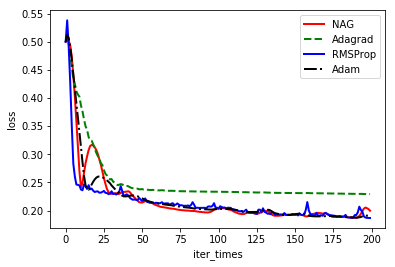

In [79]:
plt.figure()
plt.plot(iter_list,train_nag,color = 'red',linewidth = 2.0,label = 'NAG')
plt.plot(iter_list,train_adagrad,linestyle = '--',color = 'green',linewidth = 2.0 , label = 'Adagrad')
plt.plot(iter_list,train_RMSProp,linestyle = '-',color = 'blue',linewidth = 2.0 , label = 'RMSProp')
plt.plot(iter_list,train_adam,linestyle = '-.',color = 'black',linewidth = 2.0, label = 'Adam')
plt.xlabel('iter_times')  
plt.ylabel('loss')
plt.legend()
plt.show()
#SGD results in a shunk